In [1]:
%cd ..

/home/romet/projects/ut/wp4/nvidia-e2e


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

from dataloading.nvidia import NvidiaDataset, NvidiaValidationDataset, Normalize
from pilotnet import PilotnetControl, PilotNetConditional
from metrics.metrics import calculate_open_loop_metrics
from viz.analytics import create_waypoint_error_plot, create_steering_angle_error_plot

from trainer import ControlTrainer, ConditionalTrainer
from torchvision import transforms


%load_ext autoreload 
%autoreload 2

In [3]:
def create_model_conditional(model_name, n_branches=3, n_outputs=20):
    model = PilotNetConditional(3, n_branches=n_branches, n_outputs=n_outputs)
    model.load_state_dict(torch.load(f"/home/romet/projects/ut/wp4/nvidia-e2e/models/{model_name}/best.pt"))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model

def create_model_control(model_name, n_outputs=20):
    model = PilotnetControl(3, n_outputs)
    model.load_state_dict(torch.load(f"/home/romet/projects/ut/wp4/nvidia-e2e/models/{model_name}/best.pt"))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model

In [11]:
from metrics.metrics import calculate_trajectory_open_loop_metrics, calculate_open_loop_metrics
from trajectory import calculate_steering_angle
import math

def calculate_waypoint_metrics(model, trainer, dataset_name, n_waypoints=10, n_branches=3):
    root_path = Path("/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021")
    tr = transforms.Compose([Normalize()])
    dataset = NvidiaDataset([root_path / dataset_name], transform=tr, n_branches=n_branches,
                            output_modality="waypoints", n_waypoints=n_waypoints)
    #dataset = NvidiaValidationDataset(root_path, output_modality="waypoints", 
    #                        n_waypoints=n_waypoints, n_branches=n_branches)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=16)
    predicted_waypoints = trainer.predict(model, dataloader)
    
    wp_x_cols = [col for col in dataset.frames.columns if col.startswith('wp_x')]
    wp_y_cols = [col for col in dataset.frames.columns if col.startswith('wp_y')]
    waypoint_cols = np.column_stack((wp_x_cols, wp_y_cols)).reshape(-1)
    true_waypoints = dataset.frames[waypoint_cols].to_numpy()
    trajectory_metrics = calculate_trajectory_open_loop_metrics(predicted_waypoints, true_waypoints, fps=30)
    
    true_steering_angles = dataset.frames.steering_angle.to_numpy()
    pred_steering_angles = []
    #wp_progress_bar = tqdm(total=len(predicted_waypoints), smoothing=0)
    #wp_progress_bar.set_description("Calculating steering angles")
    for wp in tqdm(predicted_waypoints):
        steering_angle_wp = [0.0, 0.0]
        steering_angle_wp.extend(wp[:10])
        pred_steering_angles.append(calculate_steering_angle(steering_angle_wp, ref_distance=8))
        #wp_progress_bar.update(1)
    
    steering_metrics = calculate_open_loop_metrics(np.array(pred_steering_angles), true_steering_angles, fps=30)
    
    return trajectory_metrics, steering_metrics

def calculate_steering_metrics(model, trainer, dataset_name, n_branches=3):
    root_path = Path("/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021")
    tr = transforms.Compose([Normalize()])
    dataset = NvidiaDataset([root_path / dataset_name], transform=tr, 
                            n_branches=n_branches, output_modality="steering_angle")
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=16)
    predicted_steering_angles = trainer.predict(model, dataloader)
    true_steering_angles = dataset.frames.steering_angle.to_numpy()
    steering_metrics = calculate_open_loop_metrics(predicted_steering_angles, true_steering_angles, fps=30)
    
    return steering_metrics

In [12]:
def calculate_tracks_metrics(model, trainer, tracks, n_branches=3, n_waypoints=10):
    results = []
    for track in tracks:
        try:
            metrics = calculate_steering_metrics(model, trainer, track, n_branches=n_branches)
            metrics['track'] = track
            results.append(metrics)
        except Exception as e:
            print(f"Cannot calculate metrics for {track}")
            print(e)
        

    df = pd.DataFrame(data=results)
    df.set_index('track', inplace=True)
    return df

In [45]:
tracks = [
    "2021-06-09-13-14-51_e2e_rec_ss2",
    "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
    "2021-06-09-14-58-11_e2e_rec_ss3",
    "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
    "2021-06-09-16-24-59_e2e_rec_ss13",
    "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
    "2021-06-10-12-59-59_e2e_ss4",
    "2021-06-10-13-19-22_e2e_ss4_backwards",
    "2021-06-10-13-51-34_e2e_ss12",
    "2021-06-10-14-02-24_e2e_ss12_backwards",
    "2021-06-10-14-44-24_e2e_ss3_backwards",
    "2021-06-10-15-03-16_e2e_ss3_backwards",
    "2021-06-14-11-08-19_e2e_rec_ss14",
    "2021-06-14-11-22-05_e2e_rec_ss14",
    "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
    "2021-09-24-11-19-25_e2e_rec_ss10",
    "2021-09-24-11-40-24_e2e_rec_ss10_2",
    "2021-09-24-12-02-32_e2e_rec_ss10_3",
    "2021-09-24-12-21-20_e2e_rec_ss10_backwards",
    "2021-09-24-13-39-38_e2e_rec_ss11",
    "2021-09-30-13-57-00_e2e_rec_ss14",
    "2021-09-30-15-03-37_e2e_ss14_from_half_way",
    "2021-09-30-15-20-14_e2e_ss14_backwards",
    "2021-09-30-15-56-59_e2e_ss14_attempt_2",
    "2021-10-07-11-05-13_e2e_rec_ss3",
    "2021-10-07-11-44-52_e2e_rec_ss3_backwards",
    "2021-10-07-12-54-17_e2e_rec_ss4",
    "2021-10-07-13-22-35_e2e_rec_ss4_backwards",
    "2021-10-11-16-06-44_e2e_rec_ss2",
    "2021-10-11-17-10-23_e2e_rec_last_part",
    "2021-10-11-17-14-40_e2e_rec_backwards",
    "2021-10-11-17-20-12_e2e_rec_backwards",
    "2021-10-20-14-55-47_e2e_rec_vastse_ss13_17",
    "2021-10-20-13-57-51_e2e_rec_neeruti_ss19_22",
    "2021-10-20-14-15-07_e2e_rec_neeruti_ss19_22_back",
    "2021-10-25-17-31-48_e2e_rec_ss2_arula",
    "2021-10-25-17-06-34_e2e_rec_ss2_arula_back",
    "2021-05-28-15-19-48_e2e_sulaoja_20_30",
    "2021-06-07-14-20-07_e2e_rec_ss6",
    "2021-06-07-14-06-31_e2e_rec_ss6",
    "2021-06-07-14-09-18_e2e_rec_ss6",
    "2021-06-07-14-36-16_e2e_rec_ss6",
    "2021-09-24-14-03-45_e2e_rec_ss11_backwards",
    "2021-10-26-10-49-06_e2e_rec_ss20_elva",
    "2021-10-26-11-08-59_e2e_rec_ss20_elva_back",
    "2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back",
    "2021-10-11-14-50-59_e2e_rec_vahi",
    "2021-10-14-13-08-51_e2e_rec_vahi_backwards"
    
]

In [104]:
conditional_model = create_model_conditional('20220511114023_cond-steering-angle', n_branches=3, n_outputs=1)
conditional_trainer = ConditionalTrainer()

control_model = create_model_control('20220511132914_control-steering-angle', n_outputs=1)
control_trainer = ControlTrainer()
control_trainer.save_dir = Path("models/20220511132914_control-steering-angle")

In [116]:
??control_trainer.create_onxx_input

In [105]:
root_path = Path("/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021")
tr = transforms.Compose([Normalize()])
dataset = NvidiaDataset([root_path / "2021-10-11-14-50-59_e2e_rec_vahi"], transform=tr, 
                        n_branches=1, output_modality="steering_angle")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=1)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=21211, filtered=2


In [106]:
control_trainer.save_onnx(control_model, dataloader)

In [107]:
from torch.nn import functional as F

In [111]:
data = iter(dataloader).next()
turn_signal = data[0]['turn_signal'][0]

In [112]:
F.one_hot(turn_signal, 3).to(torch.float32)

tensor([0., 1., 0.])

In [47]:
cond_df = calculate_tracks_metrics(conditional_model, conditional_trainer, tracks)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-13-14-51_e2e_rec_ss2: lenght=49918, filtered=1


  0%|          | 0/1560 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-13-55-03_e2e_rec_ss2_backwards: lenght=53743, filtered=0


  0%|          | 0/1680 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-14-58-11_e2e_rec_ss3: lenght=43186, filtered=700


  0%|          | 0/1350 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-15-42-05_e2e_rec_ss3_backwards: lenght=40694, filtered=0


  0%|          | 0/1272 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-16-24-59_e2e_rec_ss13: lenght=33885, filtered=540


  0%|          | 0/1059 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-16-50-22_e2e_rec_ss13_backwards: lenght=34411, filtered=0


  0%|          | 0/1076 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-12-59-59_e2e_ss4: lenght=25508, filtered=0


  0%|          | 0/798 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-13-19-22_e2e_ss4_backwards: lenght=23844, filtered=1


  0%|          | 0/746 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-13-51-34_e2e_ss12: lenght=13638, filtered=1


  0%|          | 0/427 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-14-02-24_e2e_ss12_backwards: lenght=12574, filtered=0


  0%|          | 0/393 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-14-44-24_e2e_ss3_backwards: lenght=31838, filtered=0


  0%|          | 0/995 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-15-03-16_e2e_ss3_backwards: lenght=2458, filtered=0


  0%|          | 0/77 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-14-11-08-19_e2e_rec_ss14: lenght=14672, filtered=1


  0%|          | 0/459 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-14-11-22-05_e2e_rec_ss14: lenght=26043, filtered=0


  0%|          | 0/814 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-14-11-43-48_e2e_rec_ss14_backwards: lenght=43674, filtered=0


  0%|          | 0/1365 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-11-19-25_e2e_rec_ss10: lenght=34760, filtered=0


  0%|          | 0/1087 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-11-40-24_e2e_rec_ss10_2: lenght=16223, filtered=0


  0%|          | 0/507 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-12-02-32_e2e_rec_ss10_3: lenght=8142, filtered=0


  0%|          | 0/255 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-12-21-20_e2e_rec_ss10_backwards: lenght=64975, filtered=0


  0%|          | 0/2031 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-13-39-38_e2e_rec_ss11: lenght=33255, filtered=0


  0%|          | 0/1040 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-13-57-00_e2e_rec_ss14: lenght=3287, filtered=0


  0%|          | 0/103 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-15-03-37_e2e_ss14_from_half_way: lenght=21755, filtered=1


  0%|          | 0/680 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-15-20-14_e2e_ss14_backwards: lenght=52762, filtered=0


  0%|          | 0/1649 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-15-56-59_e2e_ss14_attempt_2: lenght=66899, filtered=0


  0%|          | 0/2091 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-11-05-13_e2e_rec_ss3: lenght=54211, filtered=1


  0%|          | 0/1695 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-11-44-52_e2e_rec_ss3_backwards: lenght=63400, filtered=1


  0%|          | 0/1982 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-12-54-17_e2e_rec_ss4: lenght=34056, filtered=0


  0%|          | 0/1065 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-13-22-35_e2e_rec_ss4_backwards: lenght=34373, filtered=0


  0%|          | 0/1075 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-16-06-44_e2e_rec_ss2: lenght=81250, filtered=1


  0%|          | 0/2540 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-17-10-23_e2e_rec_last_part: lenght=4986, filtered=3


  0%|          | 0/156 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-17-14-40_e2e_rec_backwards: lenght=5236, filtered=4


  0%|          | 0/164 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-17-20-12_e2e_rec_backwards: lenght=68954, filtered=5


  0%|          | 0/2155 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-14-55-47_e2e_rec_vastse_ss13_17: lenght=25021, filtered=0


  0%|          | 0/782 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-13-57-51_e2e_rec_neeruti_ss19_22: lenght=29395, filtered=2


  0%|          | 0/919 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-14-15-07_e2e_rec_neeruti_ss19_22_back: lenght=29639, filtered=0


  0%|          | 0/927 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-25-17-31-48_e2e_rec_ss2_arula: lenght=42414, filtered=1


  0%|          | 0/1326 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-25-17-06-34_e2e_rec_ss2_arula_back: lenght=43298, filtered=0


  0%|          | 0/1354 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10708, filtered=0


  0%|          | 0/335 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25836, filtered=1


  0%|          | 0/808 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=3003, filtered=0


  0%|          | 0/94 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4551, filtered=1


  0%|          | 0/143 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25368, filtered=1


  0%|          | 0/793 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25172, filtered=0


  0%|          | 0/787 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=33045, filtered=0


  0%|          | 0/1033 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33281, filtered=0


  0%|          | 0/1041 [00:00<?, ?it/s]

Cannot calculate metrics for 2021-10-26-11-08-59_e2e_rec_ss20_elva_back
iteration over a 0-d array
/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26763, filtered=0


  0%|          | 0/837 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=21211, filtered=2


  0%|          | 0/663 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-14-13-08-51_e2e_rec_vahi_backwards: lenght=13442, filtered=0


  0%|          | 0/421 [00:00<?, ?it/s]

In [48]:
control_df = calculate_tracks_metrics(control_model, control_trainer, tracks)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-13-14-51_e2e_rec_ss2: lenght=49918, filtered=1


  0%|          | 0/1560 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-13-55-03_e2e_rec_ss2_backwards: lenght=53743, filtered=0


  0%|          | 0/1680 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-14-58-11_e2e_rec_ss3: lenght=43186, filtered=700


  0%|          | 0/1350 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-15-42-05_e2e_rec_ss3_backwards: lenght=40694, filtered=0


  0%|          | 0/1272 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-16-24-59_e2e_rec_ss13: lenght=33885, filtered=540


  0%|          | 0/1059 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-09-16-50-22_e2e_rec_ss13_backwards: lenght=34411, filtered=0


  0%|          | 0/1076 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-12-59-59_e2e_ss4: lenght=25508, filtered=0


  0%|          | 0/798 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-13-19-22_e2e_ss4_backwards: lenght=23844, filtered=1


  0%|          | 0/746 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-13-51-34_e2e_ss12: lenght=13638, filtered=1


  0%|          | 0/427 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-14-02-24_e2e_ss12_backwards: lenght=12574, filtered=0


  0%|          | 0/393 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-14-44-24_e2e_ss3_backwards: lenght=31838, filtered=0


  0%|          | 0/995 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-10-15-03-16_e2e_ss3_backwards: lenght=2458, filtered=0


  0%|          | 0/77 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-14-11-08-19_e2e_rec_ss14: lenght=14672, filtered=1


  0%|          | 0/459 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-14-11-22-05_e2e_rec_ss14: lenght=26043, filtered=0


  0%|          | 0/814 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-14-11-43-48_e2e_rec_ss14_backwards: lenght=43674, filtered=0


  0%|          | 0/1365 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-11-19-25_e2e_rec_ss10: lenght=34760, filtered=0


  0%|          | 0/1087 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-11-40-24_e2e_rec_ss10_2: lenght=16223, filtered=0


  0%|          | 0/507 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-12-02-32_e2e_rec_ss10_3: lenght=8142, filtered=0


  0%|          | 0/255 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-12-21-20_e2e_rec_ss10_backwards: lenght=64975, filtered=0


  0%|          | 0/2031 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-13-39-38_e2e_rec_ss11: lenght=33255, filtered=0


  0%|          | 0/1040 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-13-57-00_e2e_rec_ss14: lenght=3287, filtered=0


  0%|          | 0/103 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-15-03-37_e2e_ss14_from_half_way: lenght=21755, filtered=1


  0%|          | 0/680 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-15-20-14_e2e_ss14_backwards: lenght=52762, filtered=0


  0%|          | 0/1649 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-30-15-56-59_e2e_ss14_attempt_2: lenght=66899, filtered=0


  0%|          | 0/2091 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-11-05-13_e2e_rec_ss3: lenght=54211, filtered=1


  0%|          | 0/1695 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-11-44-52_e2e_rec_ss3_backwards: lenght=63400, filtered=1


  0%|          | 0/1982 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-12-54-17_e2e_rec_ss4: lenght=34056, filtered=0


  0%|          | 0/1065 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-07-13-22-35_e2e_rec_ss4_backwards: lenght=34373, filtered=0


  0%|          | 0/1075 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-16-06-44_e2e_rec_ss2: lenght=81250, filtered=1


  0%|          | 0/2540 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-17-10-23_e2e_rec_last_part: lenght=4986, filtered=3


  0%|          | 0/156 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-17-14-40_e2e_rec_backwards: lenght=5236, filtered=4


  0%|          | 0/164 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-17-20-12_e2e_rec_backwards: lenght=68954, filtered=5


  0%|          | 0/2155 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-14-55-47_e2e_rec_vastse_ss13_17: lenght=25021, filtered=0


  0%|          | 0/782 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-13-57-51_e2e_rec_neeruti_ss19_22: lenght=29395, filtered=2


  0%|          | 0/919 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-14-15-07_e2e_rec_neeruti_ss19_22_back: lenght=29639, filtered=0


  0%|          | 0/927 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-25-17-31-48_e2e_rec_ss2_arula: lenght=42414, filtered=1


  0%|          | 0/1326 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-25-17-06-34_e2e_rec_ss2_arula_back: lenght=43298, filtered=0


  0%|          | 0/1354 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10708, filtered=0


  0%|          | 0/335 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25836, filtered=1


  0%|          | 0/808 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=3003, filtered=0


  0%|          | 0/94 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4551, filtered=1


  0%|          | 0/143 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25368, filtered=1


  0%|          | 0/793 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25172, filtered=0


  0%|          | 0/787 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=33045, filtered=0


  0%|          | 0/1033 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33281, filtered=0


  0%|          | 0/1041 [00:00<?, ?it/s]

Cannot calculate metrics for 2021-10-26-11-08-59_e2e_rec_ss20_elva_back
iteration over a 0-d array
/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26763, filtered=0


  0%|          | 0/837 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=21211, filtered=2


  0%|          | 0/663 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-14-13-08-51_e2e_rec_vahi_backwards: lenght=13442, filtered=0


  0%|          | 0/421 [00:00<?, ?it/s]

In [50]:
filtered_columns = ["mae", "rmse", "max", "whiteness"]
sum_df = pd.concat([cond_df[filtered_columns], control_df[filtered_columns]], axis=1)
sum_df.columns = ["m1_mae", "m1_rmse", "m1_max", "m1_whiteness",
                  "m2_mae", "m2_rmse", "m2_max", "m2_whiteness"]
sum_df.sort_values(by=['m1_max'], ascending=False)

,m1_mae,m1_rmse,m1_max,m1_whiteness,m2_mae,m2_rmse,m2_max,m2_whiteness
track,,,,,,,,
2021-06-07-14-36-16_e2e_rec_ss6,7.785928,23.452771,442.200125,82.470963,8.177344,23.227894,419.513798,90.362289
2021-06-07-14-09-18_e2e_rec_ss6,19.571728,72.694659,439.252191,103.462769,14.227538,49.953400,302.054289,116.721680
2021-10-07-11-44-52_e2e_rec_ss3_backwards,6.174713,20.007550,422.368856,67.413483,4.784731,9.759673,210.280641,64.670044
2021-06-07-14-20-07_e2e_rec_ss6,7.154522,25.136735,420.911349,61.800575,6.114691,18.284240,310.585832,67.127625
2021-10-11-16-06-44_e2e_rec_ss2,5.016327,14.741327,396.363361,56.477428,3.998205,8.106049,187.104210,58.449192
2021-09-24-14-03-45_e2e_rec_ss11_backwards,7.316493,19.256672,382.925450,103.597519,9.217934,29.173216,440.322645,96.528450
2021-09-24-11-40-24_e2e_rec_ss10_2,6.706452,18.997907,339.470023,128.723495,7.394610,23.640762,407.186656,136.152969
2021-06-10-13-19-22_e2e_ss4_backwards,7.875069,17.327490,319.901947,136.720963,7.738252,17.379404,290.497040,161.243790
2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back,11.623010,23.913571,309.387892,143.126038,10.815706,19.999774,237.671843,113.559685


In [54]:
dataset_name = "2021-09-24-14-03-45_e2e_rec_ss11_backwards"

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25172, filtered=0


  0%|          | 0/787 [00:00<?, ?it/s]

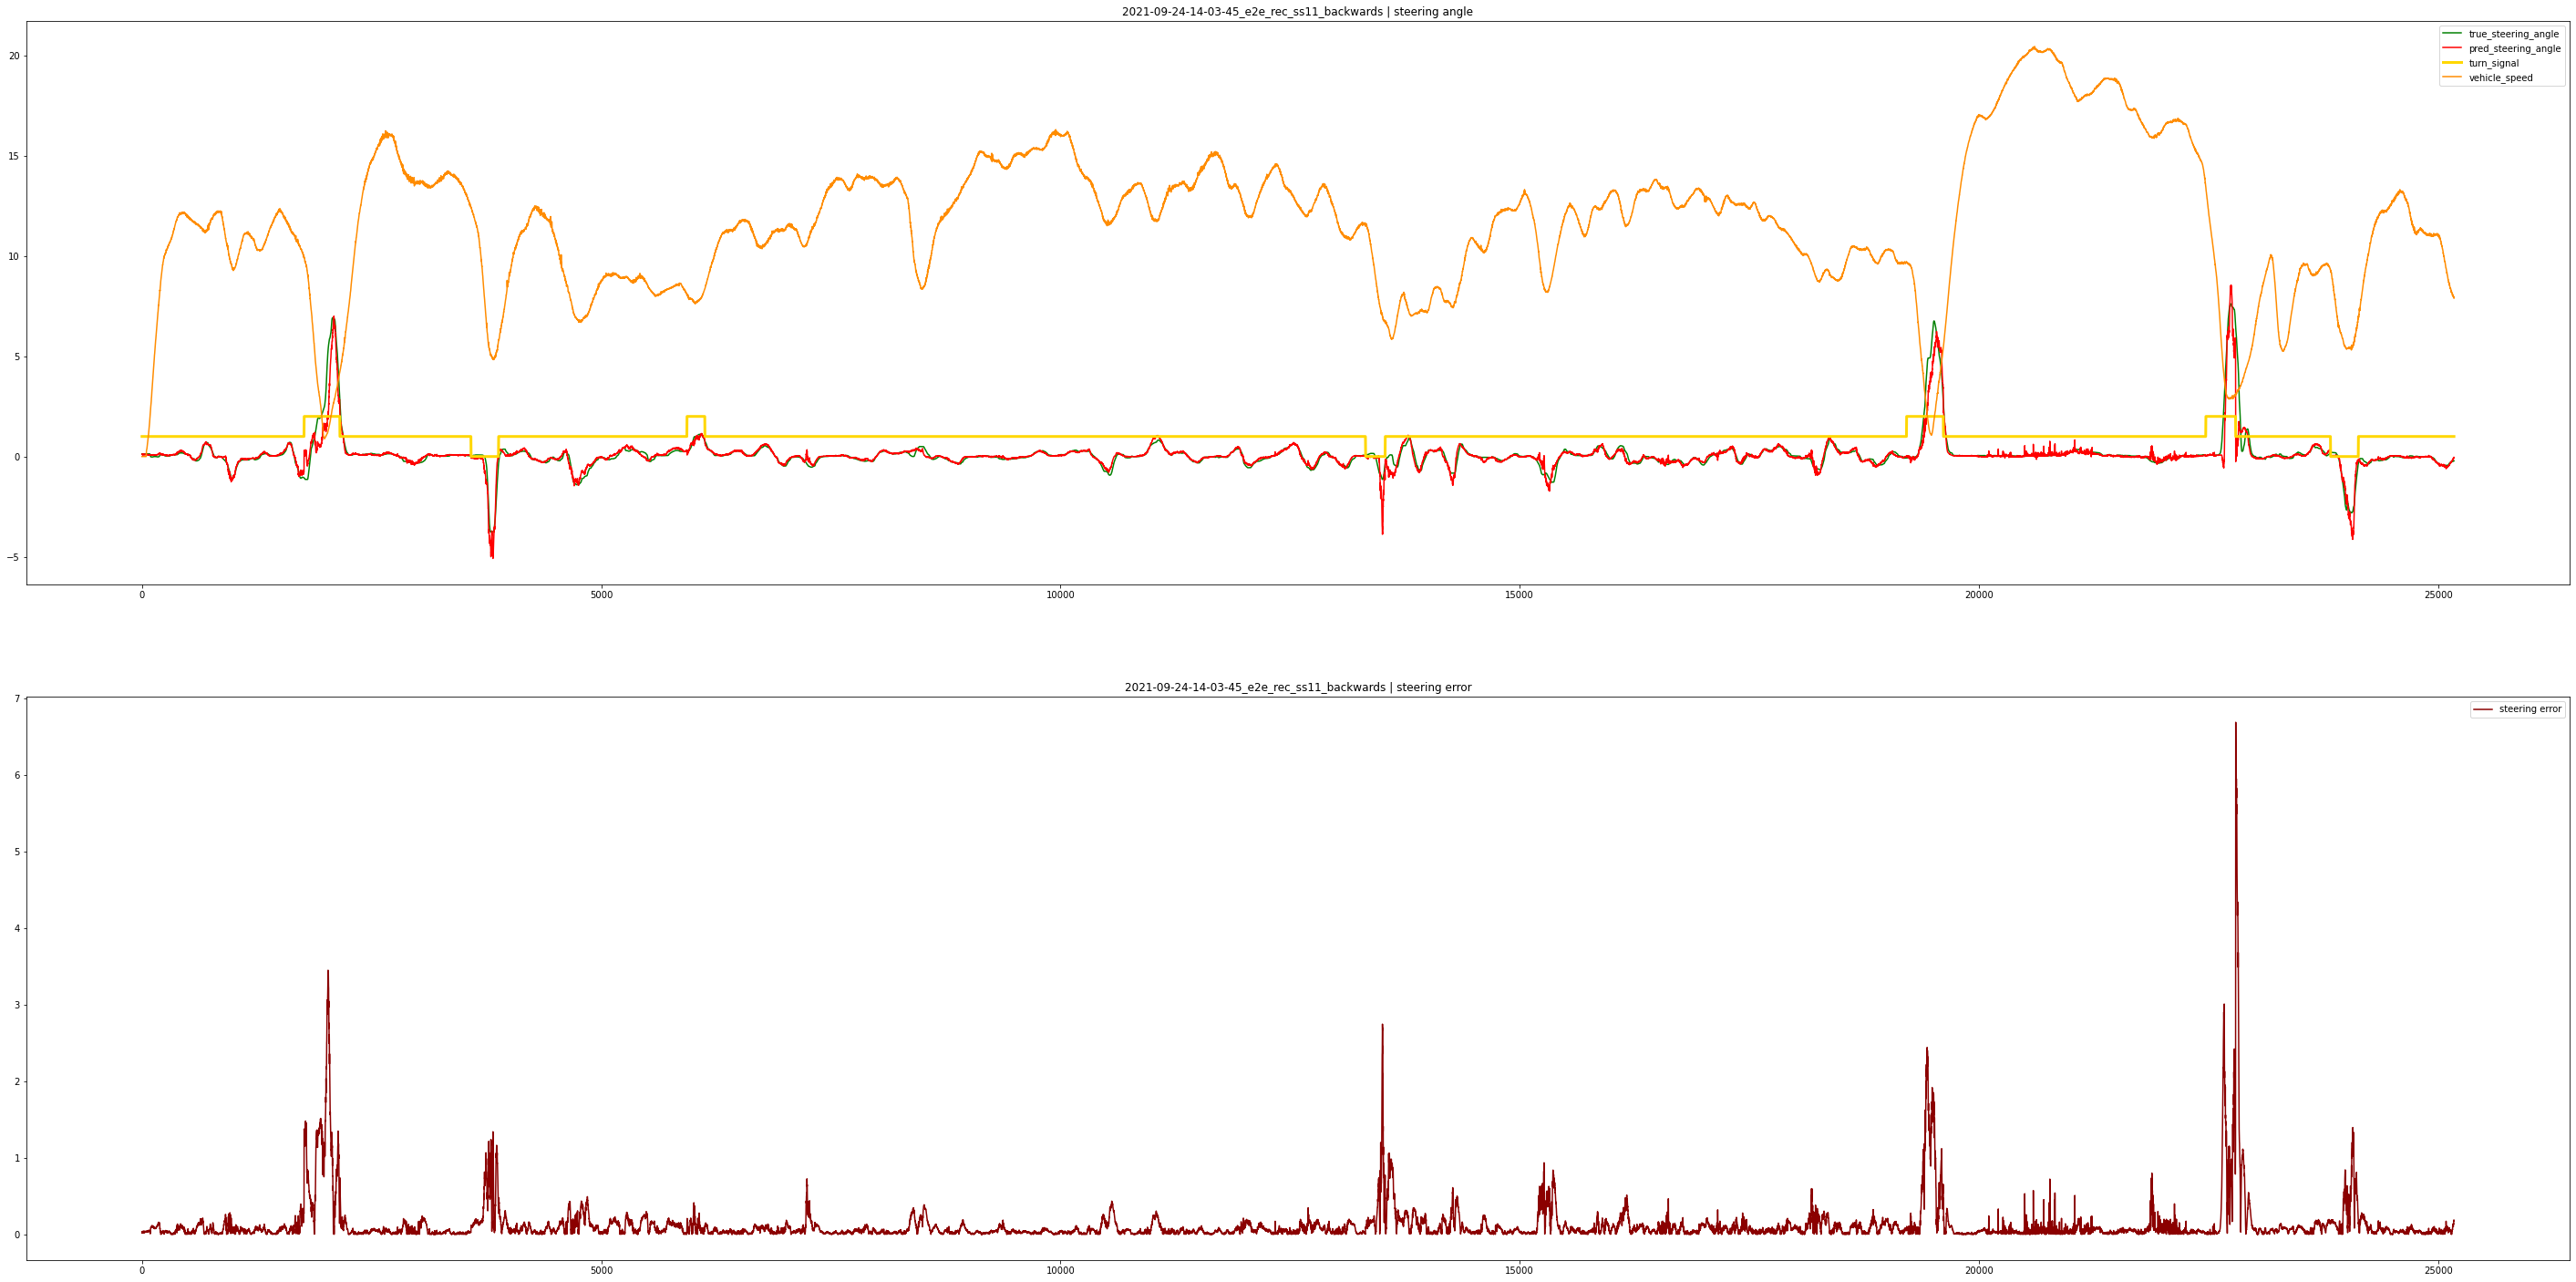

In [55]:
create_steering_angle_error_plot(conditional_model, conditional_trainer, dataset_name)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25172, filtered=0


  0%|          | 0/787 [00:00<?, ?it/s]

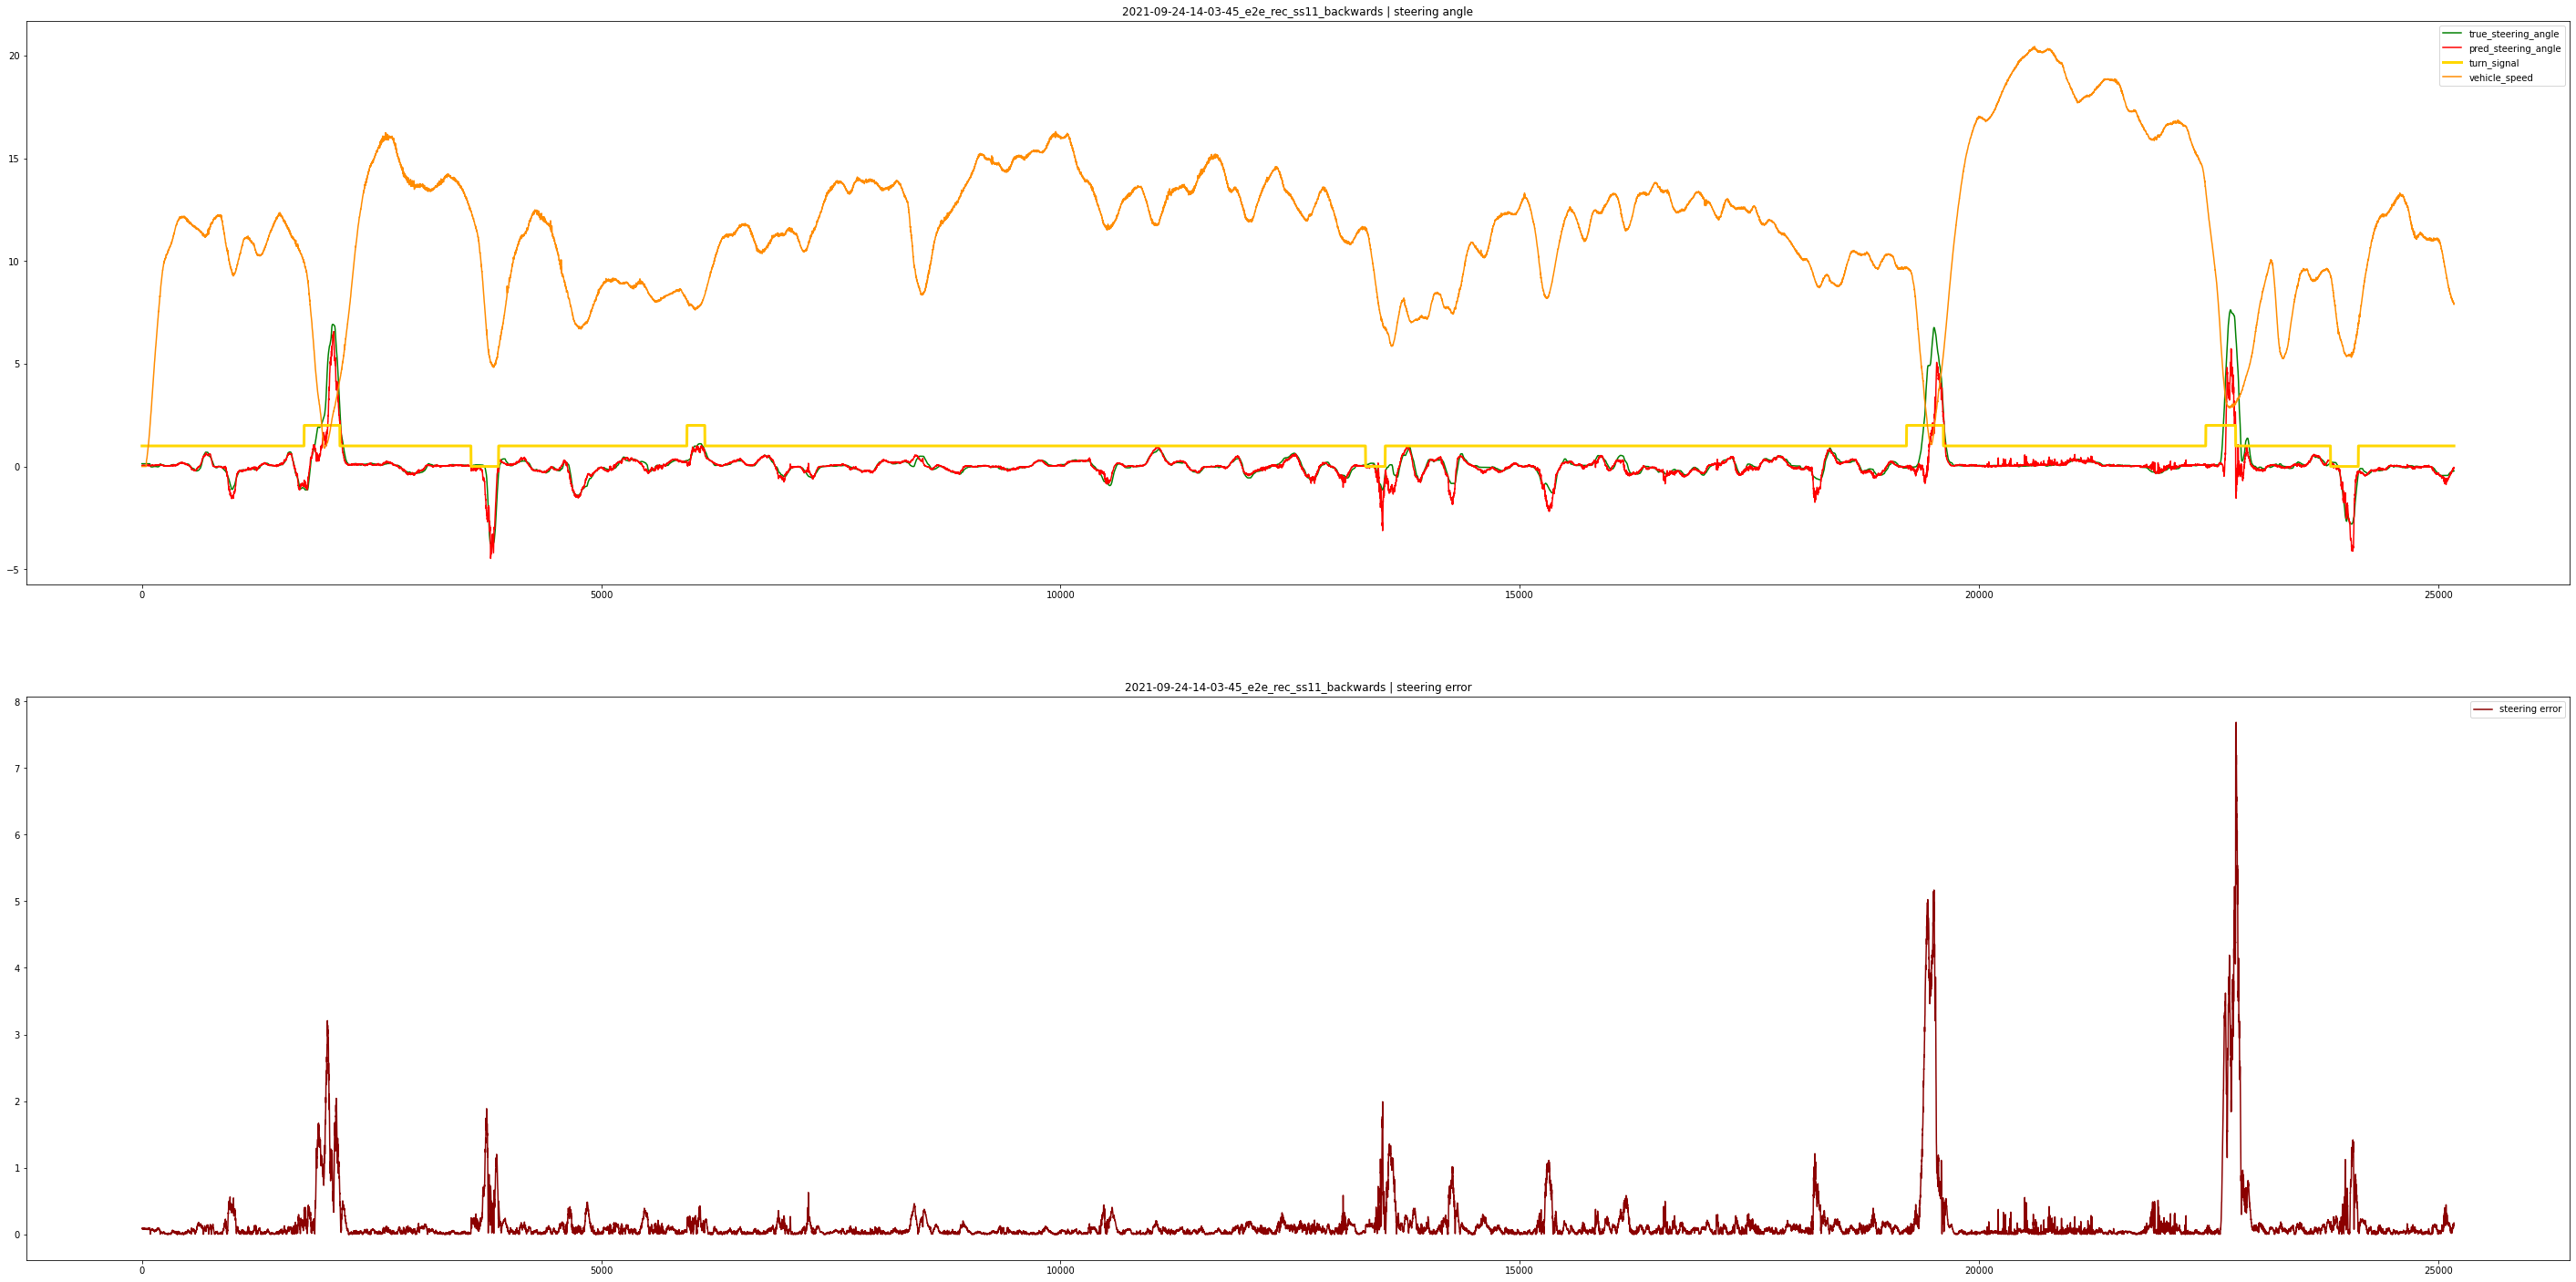

In [56]:
create_steering_angle_error_plot(control_model, control_trainer, dataset_name)